In [2]:

!pip install scikit-learn==1.2.2 imbalanced-learn==0.11.0

# -----------------------
# Imports & Environment
# -----------------------

import os
import time
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, roc_curve, precision_recall_curve,
    auc, matthews_corrcoef, classification_report
)
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from imblearn.over_sampling import SMOTE
import joblib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.6/235.6 kB 7.0 MB/s eta 0:00:00
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.13.0
    Uninstalling imbalanced-learn-0.13.0:
      Successfully uninstalled imbalanced-learn-0.13.0


In [8]:
# -----------------------
# Load dataset
# -----------------------
df = pd.read_csv("/kaggle/input/fraud-detection-dataset/AIML Dataset.csv")

print("Loaded shape:", df.shape)
display(df.head())
display(df.tail())
df.isna().sum()

Loaded shape: (6362620, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.0,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.0,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.0,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.0,C2080388513,0.00,0.00,1,0
6362619,743,CASH_OUT,850002.52,C1280323807,850002.52,0.0,C873221189,6510099.11,7360101.63,1,0


step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

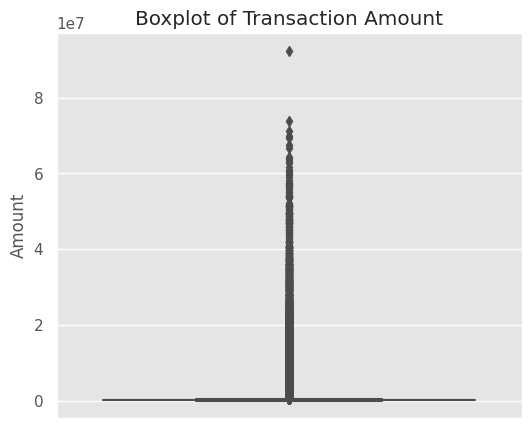

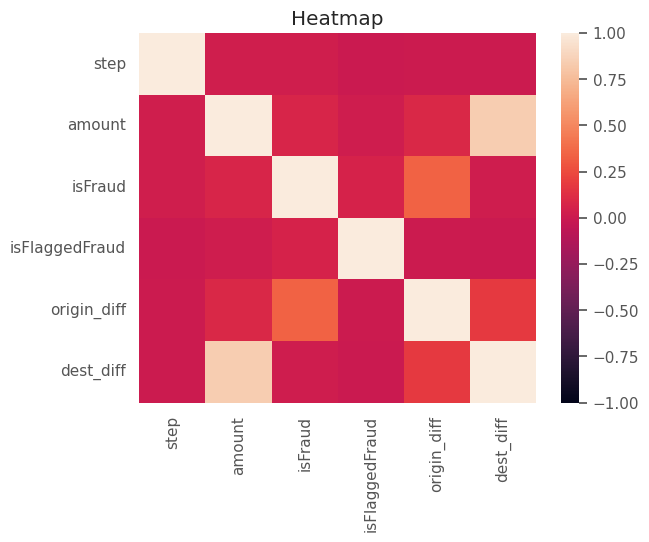

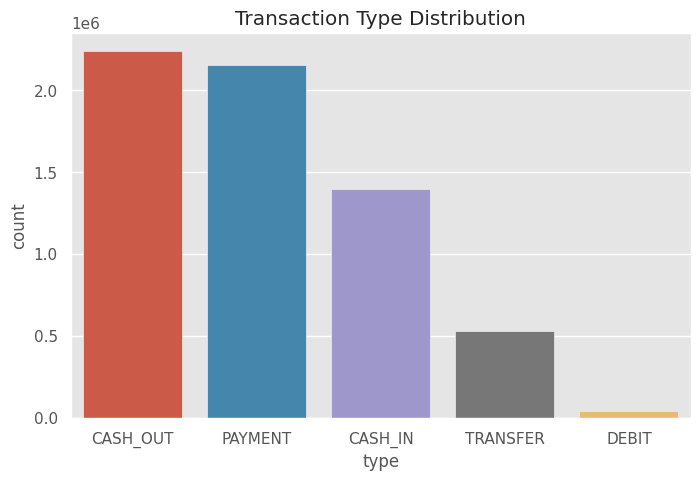

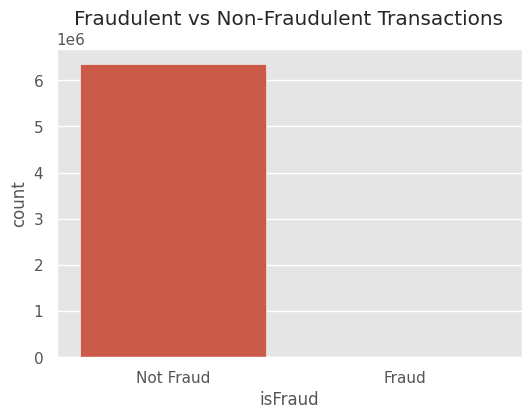

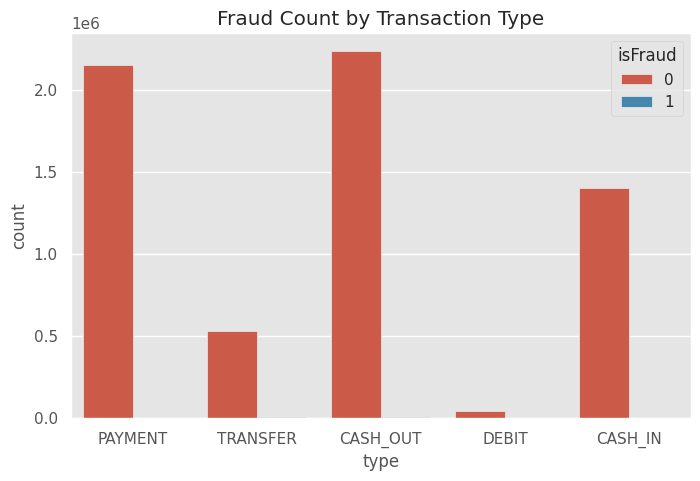

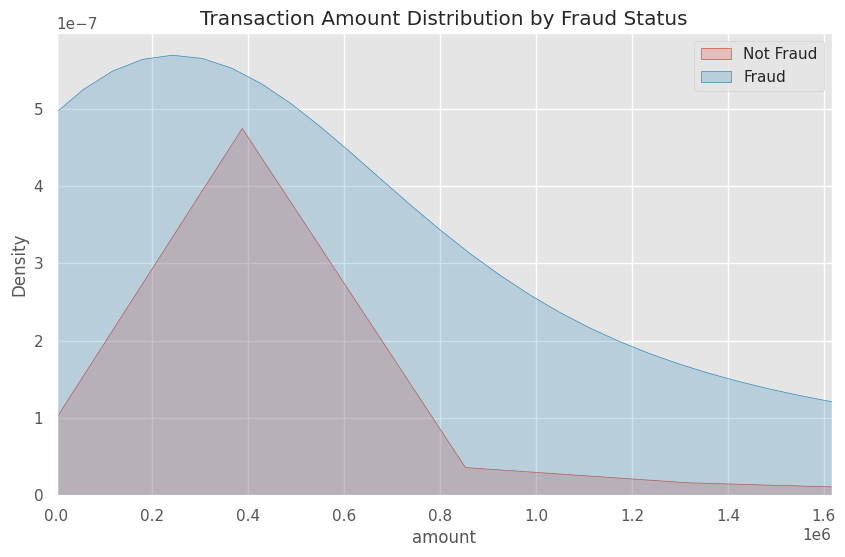

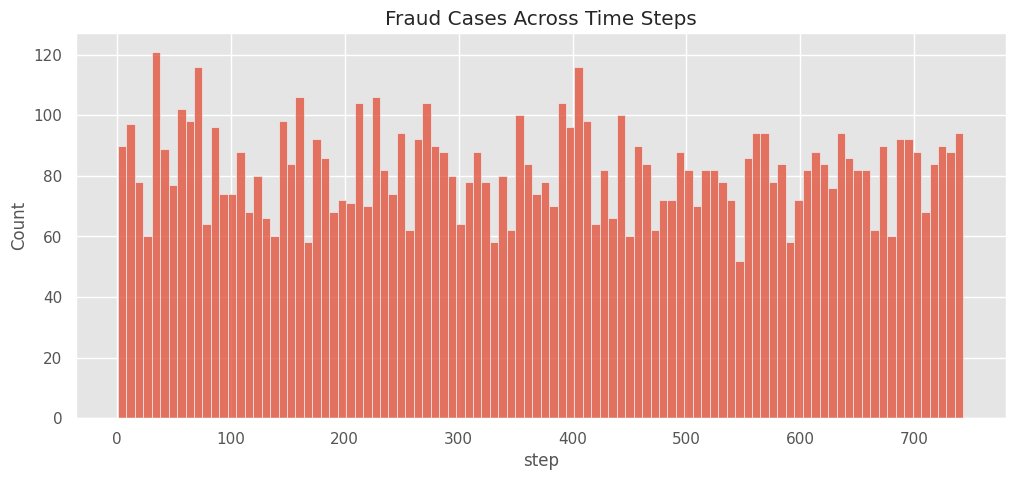

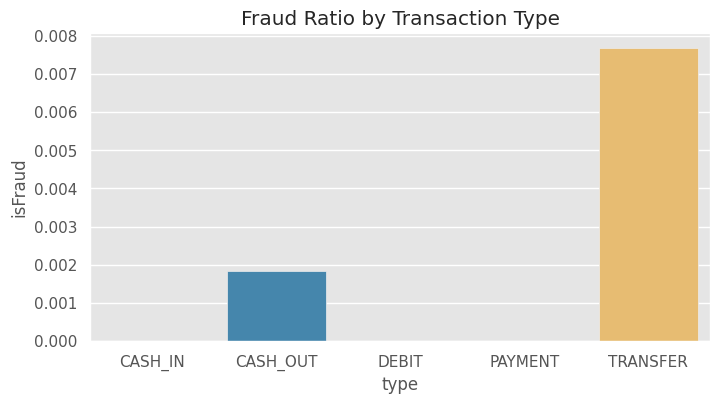

In [24]:
# -----------------------
# EDA & Visualization
# -----------------------

sns.set(style="whitegrid")
plt.style.use('ggplot')


plt.figure(figsize=(6,5))
sns.boxplot(y=df['amount'], color='Red')
plt.title("Boxplot of Transaction Amount")
plt.ylabel("Amount")
plt.show()


sample = df.sample(200000, random_state=42)
corr = sample.select_dtypes(include=[np.number]).corr()
sns.heatmap(corr, annot=False, vmax=1, vmin=-1); 
plt.title('Heatmap')
plt.show()


plt.figure(figsize=(8,5))
sns.countplot(data=df, x='type', order=df['type'].value_counts().index)
plt.title("Transaction Type Distribution")
plt.show()

plt.figure(figsize=(6,4))
sns.countplot(x='isFraud', data=df)
plt.title('Fraudulent vs Non-Fraudulent Transactions')
plt.xticks([0,1], ['Not Fraud', 'Fraud'])
plt.show()

plt.figure(figsize=(8,5))
sns.countplot(x='type', hue='isFraud', data=df)
plt.title('Fraud Count by Transaction Type')
plt.show()

plt.figure(figsize=(10,6))
sns.kdeplot(data=df[df['isFraud'] == 0]['amount'], label='Not Fraud', fill=True)
sns.kdeplot(data=df[df['isFraud'] == 1]['amount'], label='Fraud', fill=True)
plt.xlim(0, df['amount'].quantile(0.99))
plt.title('Transaction Amount Distribution by Fraud Status')
plt.legend()
plt.show()


plt.figure(figsize=(12,5))
sns.histplot(df[df['isFraud']==1]['step'], bins=100)
plt.title('Fraud Cases Across Time Steps')
plt.show()


fraud_ratio = df.groupby('type')['isFraud'].mean().reset_index()
plt.figure(figsize=(8,4))
sns.barplot(x='type', y='isFraud', data=fraud_ratio)
plt.title('Fraud Ratio by Transaction Type')
plt.show()



In [10]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
sample = df.sample(200000, random_state=42)
X = sample[['amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest','step']]
vif = pd.DataFrame({'var': X.columns, 'VIF': [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]})
print(vif)

              var         VIF
0          amount    3.849771
1   oldbalanceOrg  516.108133
2  newbalanceOrig  518.141901
3  oldbalanceDest   70.425374
4  newbalanceDest   80.995809
5            step    1.200004


In [11]:
# derived features
df['origin_diff'] = df['oldbalanceOrg'] - df['newbalanceOrig']
df['dest_diff'] = df['newbalanceDest'] - df['oldbalanceDest']

df = df.drop(['oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest'], axis=1)
display(df.head())

,step,type,amount,nameOrig,nameDest,isFraud,isFlaggedFraud,origin_diff,dest_diff
0,1,PAYMENT,9839.64,C1231006815,M1979787155,0,0,9839.64,0.0
1,1,PAYMENT,1864.28,C1666544295,M2044282225,0,0,1864.28,0.0
2,1,TRANSFER,181.00,C1305486145,C553264065,1,0,181.00,0.0
3,1,CASH_OUT,181.00,C840083671,C38997010,1,0,181.00,-21182.0
4,1,PAYMENT,11668.14,C2048537720,M1230701703,0,0,11668.14,0.0


In [12]:
# -----------------------
# Preprocessing 
# -----------------------
def preprocess(df_in):
    df_proc = df_in.copy()
    df_proc = df_proc.drop(['nameOrig','nameDest'], axis=1)

    le = LabelEncoder()
    df_proc['type'] = le.fit_transform(df_proc['type'])

    # Scale numeric
    num_cols = df_proc.select_dtypes(include=['float64','int64']).columns.tolist()
    num_cols.remove('isFraud')
    scaler = StandardScaler()
    df_proc[num_cols] = scaler.fit_transform(df_proc[num_cols])
    return df_proc

In [13]:
# -----------------------
# Subsample 20% for model exploration
# -----------------------
df_small = df.sample(frac=0.2, random_state=42).reset_index(drop=True)
df_small = preprocess(df_small)

X_small = df_small.drop('isFraud', axis=1)
y_small = df_small['isFraud']

X_train, X_test, y_train, y_test = train_test_split(
    X_small, y_small, test_size=0.3, random_state=42, stratify=y_small
)
# SMOTE on training data
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)
print("Subsample + SMOTE:", X_train_sm.shape, "Fraud ratio:", y_train_sm.mean())

Subsample + SMOTE: (1779264, 6) Fraud ratio: 0.5


In [14]:
# -----------------------
# Models to compare 
# -----------------------
models = [
    (LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42), "Logistic Regression"),
    (DecisionTreeClassifier(class_weight='balanced', random_state=42), "Decision Tree"),
    (RandomForestClassifier(n_estimators=200, n_jobs=-1, class_weight='balanced', random_state=42), "Random Forest"),
    (GaussianNB(), "Naive Bayes"),
    (XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_estimators=200, max_depth=6,
                   learning_rate=0.1, subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1), "XGBoost"),
    (LGBMClassifier(n_estimators=200, max_depth=6, learning_rate=0.1, random_state=42, n_jobs=-1), "LightGBM"),
    (CatBoostClassifier(iterations=200, depth=6, learning_rate=0.1, verbose=0, random_state=42), "CatBoost")
]

In [15]:
# -----------------------
# Evaluation function
# -----------------------
results = []

def evaluate_model(model, name):
    print("\n" + "="*70)
    print(f"Model: {name}")
    start = time.time()
    model.fit(X_train_sm, y_train_sm)
    train_time = time.time() - start

    y_pred = model.predict(X_test)
    try:
        y_score = model.predict_proba(X_test)[:,1]
    except:
        y_score = None

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    mcc = matthews_corrcoef(y_test, y_pred)

    auc_roc = roc_auc_score(y_test, y_score) if y_score is not None else np.nan
    prec_vals, recall_vals, _ = precision_recall_curve(y_test, y_score) if y_score is not None else ([],[],[])
    auc_pr = auc(recall_vals, prec_vals) if y_score is not None else np.nan

    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(cm, display_labels=["Not Fraud", "Fraud"]).plot(cmap='Blues')
    plt.title(f"{name} - Confusion Matrix")
    plt.show()

    print(f"Accuracy:  {acc:.5f}")
    print(f"Precision: {prec:.5f}")
    print(f"Recall:    {rec:.5f}")
    print(f"F1-score:  {f1:.5f}")
    print(f"ROC-AUC:   {auc_roc:.5f}")
    print(f"PR-AUC:    {auc_pr:.5f}")
    print(f"MCC:       {mcc:.5f}")

    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-score": f1,
        "ROC-AUC": auc_roc,
        "PR-AUC": auc_pr,
        "MCC": mcc,
        "Train_time_s": train_time
    })


Model: Logistic Regression


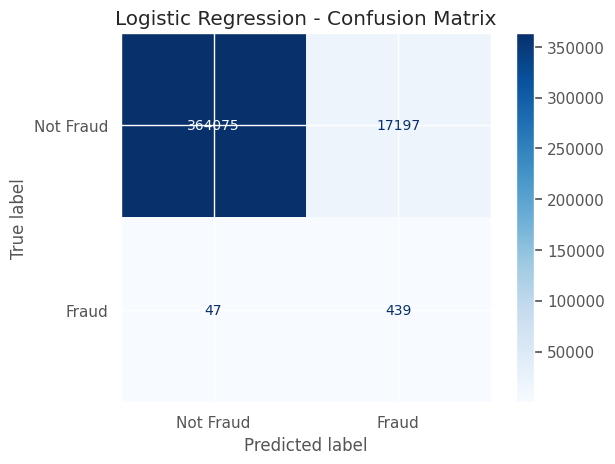

Accuracy:  0.95483
Precision: 0.02489
Recall:    0.90329
F1-score:  0.04845
ROC-AUC:   0.98045
PR-AUC:    0.58488
MCC:       0.14578

Model: Decision Tree


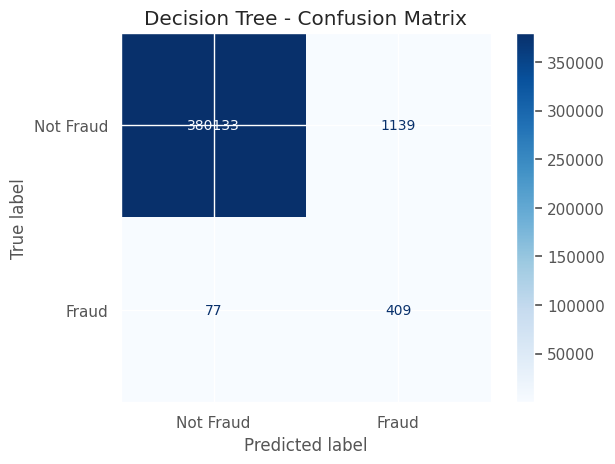

Accuracy:  0.99681
Precision: 0.26421
Recall:    0.84156
F1-score:  0.40216
ROC-AUC:   0.91929
PR-AUC:    0.55299
MCC:       0.47052

Model: Random Forest


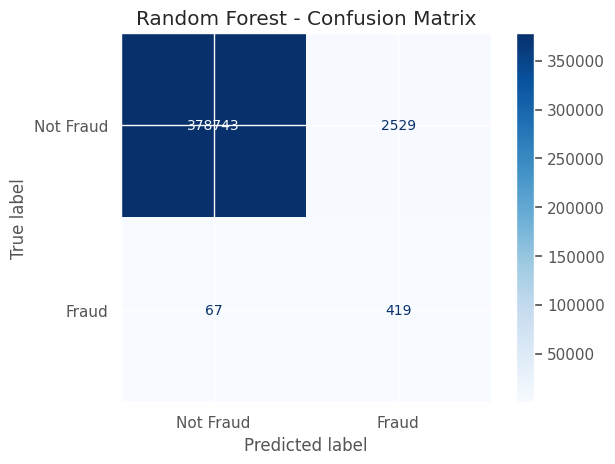

Accuracy:  0.99320
Precision: 0.14213
Recall:    0.86214
F1-score:  0.24403
ROC-AUC:   0.99068
PR-AUC:    0.74387
MCC:       0.34849

Model: Naive Bayes


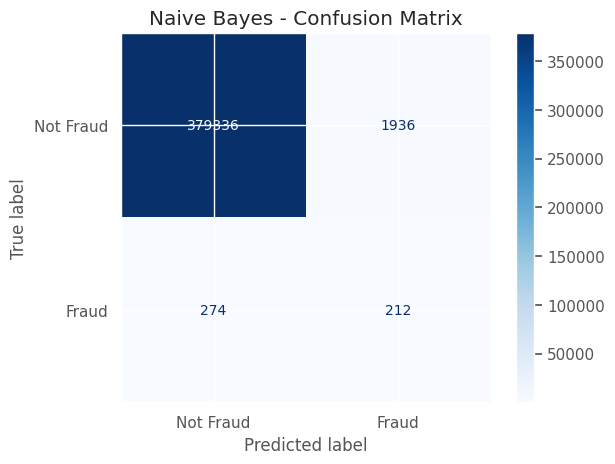

Accuracy:  0.99421
Precision: 0.09870
Recall:    0.43621
F1-score:  0.16097
ROC-AUC:   0.90637
PR-AUC:    0.21817
MCC:       0.20552

Model: XGBoost


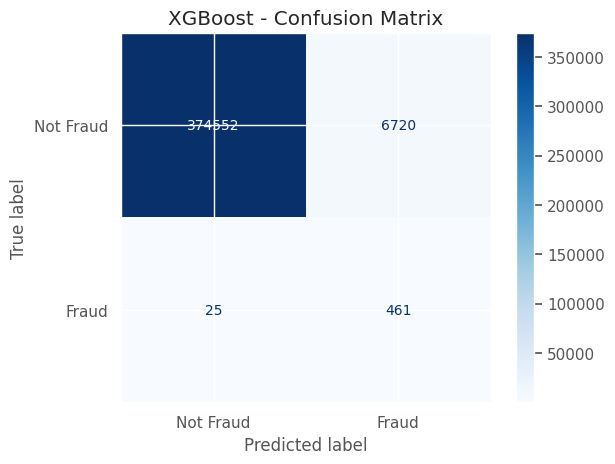

Accuracy:  0.98233
Precision: 0.06420
Recall:    0.94856
F1-score:  0.12026
ROC-AUC:   0.99534
PR-AUC:    0.85405
MCC:       0.24434

Model: LightGBM
[LightGBM] [Info] Number of positive: 889632, number of negative: 889632
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017669 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1087
[LightGBM] [Info] Number of data points in the train set: 1779264, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


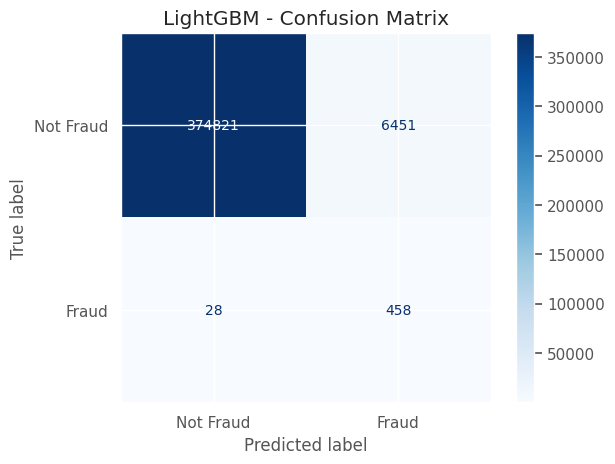

Accuracy:  0.98303
Precision: 0.06629
Recall:    0.94239
F1-score:  0.12387
ROC-AUC:   0.99533
PR-AUC:    0.85118
MCC:       0.24755

Model: CatBoost


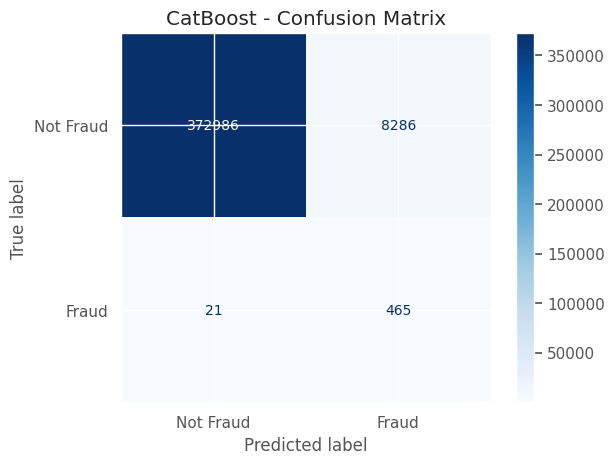

Accuracy:  0.97824
Precision: 0.05314
Recall:    0.95679
F1-score:  0.10068
ROC-AUC:   0.99521
PR-AUC:    0.83599
MCC:       0.22279


,Accuracy,Precision,Recall,F1-score,ROC-AUC,PR-AUC,MCC,Train_time_s
Model,,,,,,,,
Decision Tree,0.996815,0.264212,0.841564,0.402163,0.919288,0.552989,0.470523,10.665487
Random Forest,0.993200,0.142130,0.862140,0.244030,0.990679,0.743868,0.348485,223.002426
Naive Bayes,0.994211,0.098696,0.436214,0.160972,0.906371,0.218174,0.205525,0.285897
LightGBM,0.983029,0.066290,0.942387,0.123867,0.995331,0.851180,0.247549,9.923761
XGBoost,0.982332,0.064197,0.948560,0.120256,0.995338,0.854055,0.244338,11.343350
CatBoost,0.978240,0.053137,0.956790,0.100682,0.995215,0.835986,0.222785,31.483648
Logistic Regression,0.954830,0.024892,0.903292,0.048449,0.980453,0.584879,0.145779,6.257448


In [16]:
# -----------------------
# Run models on subsample
# -----------------------
for model, name in models:
    evaluate_model(model, name)

summary_df = pd.DataFrame(results).set_index("Model").sort_values(by="F1-score", ascending=False)
display(summary_df)

In [20]:
# Since fraud detection requires high recall + decent precision (catching as many frauds as possible, but not flagging everything as fraud), we look at F1-score + ROC-AUC, 2 model are considered for final training:
# LightGBM
# Decision Tree


=== Final Training: LightGBM ===
[LightGBM] [Info] Number of positive: 4448085, number of negative: 4448085
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.081496 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1034
[LightGBM] [Info] Number of data points in the train set: 8896170, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
              precision    recall  f1-score   support

           0    0.99994   0.98071   0.99024   1906322
           1    0.06034   0.95820   0.11353      2464

    accuracy                        0.98068   1908786
   macro avg    0.53014   0.96946   0.55188   1908786
weighted avg    0.99873   0.98068   0.98910   1908786

Training Time: 120.58 sec
Accuracy: 0.98068, Precision: 0.06034, Recall: 0.95820, F1: 0.11353, AUC: 0.99721


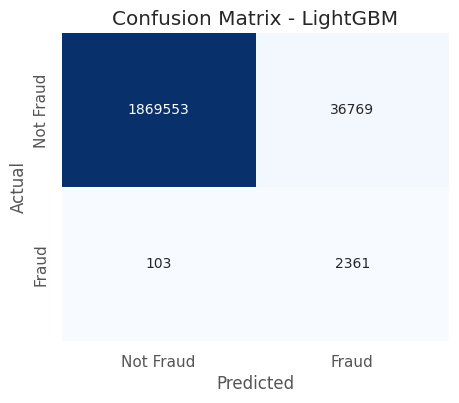


=== Final Training: Decision Tree ===
              precision    recall  f1-score   support

           0    0.99992   0.97392   0.98675   1906322
           1    0.04451   0.93994   0.08500      2464

    accuracy                        0.97388   1908786
   macro avg    0.52222   0.95693   0.53588   1908786
weighted avg    0.99869   0.97388   0.98559   1908786

Training Time: 73.34 sec
Accuracy: 0.97388, Precision: 0.04451, Recall: 0.93994, F1: 0.08500, AUC: 0.97799


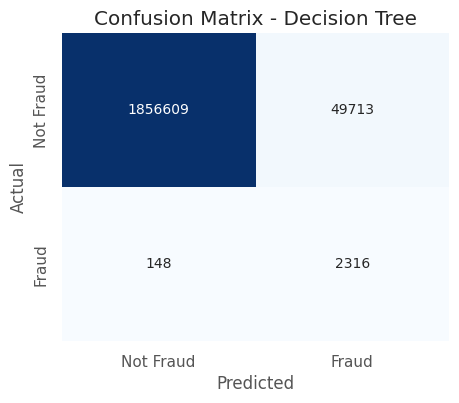


=== Final Model Comparison ===
           Model  Train Time (s)  Accuracy  Precision    Recall        F1  \
0       LightGBM      120.576113  0.980683   0.060337  0.958198  0.113526   
1  Decision Tree       73.337305  0.973878   0.044514  0.939935  0.085002   

    ROC-AUC  
0  0.997213  
1  0.977986  


In [21]:
# -----------------------
# Final training on full dataset (only LGBM + Decision Tree)
# -----------------------

df_full = preprocess(df)
X = df_full.drop('isFraud', axis=1)
y = df_full['isFraud']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

final_models = [
    
    (
        LGBMClassifier(
            n_estimators=500,          
            max_depth=-1,
            learning_rate=0.05,        
            subsample=0.8,
            colsample_bytree=0.8,
            reg_lambda=1,              
            reg_alpha=0.1,
            random_state=42,
            n_jobs=-1
        ),
        "LightGBM"
    ),

    (
        DecisionTreeClassifier(
            criterion='gini',
            splitter='best',
            max_depth=15,              
            min_samples_split=10,      
            min_samples_leaf=5,        
            class_weight='balanced',
            random_state=42
        ),
        "Decision Tree"
    )
]

final_results = []


for model, name in final_models:
    print(f"\n=== Final Training: {name} ===")
    start = time.time()
    model.fit(X_train_sm, y_train_sm)
    train_time = time.time() - start
    
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob) if y_prob is not None else np.nan

    print(classification_report(y_test, y_pred, digits=5))
    print(f"Training Time: {train_time:.2f} sec")
    print(f"Accuracy: {acc:.5f}, Precision: {prec:.5f}, Recall: {rec:.5f}, F1: {f1:.5f}, AUC: {auc:.5f}")

  # Save results
    final_results.append({
        "Model": name,
        "Train Time (s)": train_time,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "ROC-AUC": auc
    })

    # Save model
    joblib.dump(model, f"{name.replace(' ','_')}_final.joblib")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["Not Fraud", "Fraud"],
                yticklabels=["Not Fraud", "Fraud"])
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
       
results_df = pd.DataFrame(final_results)
print("\n=== Final Model Comparison ===")
print(results_df)

In [22]:
# Fine-tuning LightGBM
#It gives better ROC-AUC and similar recall.

In [25]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from lightgbm import LGBMClassifier

#  Make a smaller sample for hyperparameter tuning
X_sample, _, y_sample, _ = train_test_split(
    X_train, y_train,
    train_size=150000,  # using 150k rows instead of 4.45M
    stratify=y_train,
    random_state=42
)

# Define model & search space
lgbm = LGBMClassifier(
    objective="binary",
    class_weight="balanced",  # important for imbalance
    random_state=42
)

param_dist = {
    "num_leaves": [15, 31, 63],
    "max_depth": [-1, 5, 10, 15],
    "learning_rate": [0.01, 0.05, 0.1],
    "n_estimators": [100, 200, 300],
    "subsample": [0.7, 0.8, 1.0],
    "colsample_bytree": [0.7, 0.8, 1.0]
}

#  Randomized Search 
random_search = RandomizedSearchCV(
    lgbm,
    param_distributions=param_dist,
    n_iter=10,       
    cv=2,            
    scoring="roc_auc",
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_sample, y_sample)

print("Best Params:", random_search.best_params_)
print("Best Score:", random_search.best_score_)

# Retrain best model on full dataset with validation
# Split off validation for early stopping
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train,
    test_size=0.2,
    stratify=y_train,
    random_state=42
)

from lightgbm import early_stopping, log_evaluation

best_lgbm = LGBMClassifier(
    **random_search.best_params_,
    objective="binary",
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)


best_lgbm.fit(
    X_tr, y_tr,
    eval_set=[(X_val, y_val)],
    eval_metric="auc",
    callbacks=[
        early_stopping(stopping_rounds=20),
        log_evaluation(50)
    ]
)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[LightGBM] [Info] Number of positive: 97, number of negative: 74903
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021733 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1026
[LightGBM] [Info] Number of data points in the train set: 75000, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 97, number of negative: 74903
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023728 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1026
[LightGBM] [Info] Number of data points in the train set: 75000, number of used features: 5
[LightGBM] [Info] [b

LGBMClassifier(class_weight='balanced', colsample_bytree=0.7, max_depth=10,
               n_estimators=200, n_jobs=-1, num_leaves=15, objective='binary',
               random_state=42, subsample=0.8)

AUC Score: 0.9974501725271008
Accuracy: 0.9703146397762766

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.98   1906322
           1       0.04      0.97      0.08      2464

    accuracy                           0.97   1908786
   macro avg       0.52      0.97      0.53   1908786
weighted avg       1.00      0.97      0.98   1908786


Model saved as 'lgbm_model.pkl'


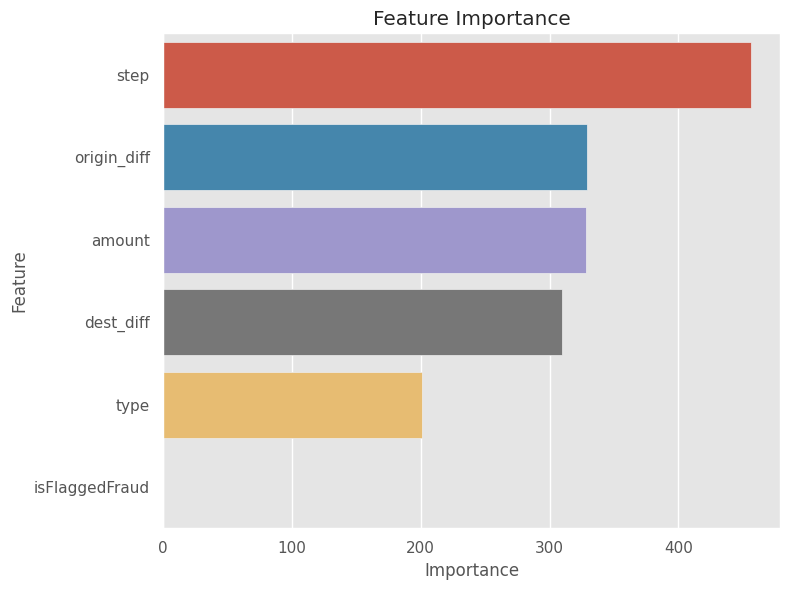

[LightGBM] [Info] Number of positive: 97, number of negative: 74903
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022787 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1026
[LightGBM] [Info] Number of data points in the train set: 75000, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 97, number of negative: 74903
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007006 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1026
[LightGBM] [Info] Number of data points in the train set: 75000, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [I

In [26]:
# ----------------------------
# Predictions on test set
# ----------------------------
y_pred = best_lgbm.predict(X_test)                 # class predictions
y_pred_proba = best_lgbm.predict_proba(X_test)[:, 1]  # probabilities

# Evaluate model
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report

print("AUC Score:", roc_auc_score(y_test, y_pred_proba))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Save the trained model
import joblib
joblib.dump(best_lgbm, "lgbm_model.pkl")
print("\nModel saved as 'lgbm_model.pkl'")

# Feature importance

feat_imp = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": best_lgbm.feature_importances_
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(x="Importance", y="Feature", data=feat_imp)
plt.title("Feature Importance")
plt.tight_layout()
plt.show()